# Boardgames meets Data Science

This data science project comes up with the idea of exploring the **boardgame market** using **Machine Learning** and **Natural Language Processing** to find what makes this games **awesome**. 

The **data** was web scraped from [BoardGameGeek](https://boardgamegeek.com/browse/boardgame) site (also known as BGG) at March 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import random

import warnings
warnings.filterwarnings("ignore")

## Dataframe: BGG top 5000 boardgames

In [12]:
url = 'https://raw.githubusercontent.com/Sampayob/Boardgames-meets-Data-science/master/BGGTop5000.csv'
df = pd.read_csv(url,delimiter = ',')
df.head(3)

,Unnamed: 0,Age,Artists,Best number of players,Categories,Designer,Family,Mechanisms,Name,Number of players,Playing time,Publishers,Rating,Weight,Year
0,0,12+,"['Alexandr Elichev', 'Josh T. McDowell', 'Alva...",— Best: 3,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",['Isaac Childres'],"['Campaign Games', 'Components: Miniatures', '...","['Action Retrieval', 'Campaign / Battle Card D...",Gloomhaven,1–4,60–120,"['Cephalofair Games', 'Albi', 'Asmodee', 'Feue...",8.8,3.82,2017
1,1,13+,['Chris Quilliams'],— Best: 4,"['Environmental', 'Medical']","['Rob Daviau', 'Matt Leacock']","['Campaign Games', 'Legacy', 'Pandemic']","['Action Points', 'Cooperative Game', 'Hand Ma...",Pandemic Legacy: Season 1,2–4,60,"['Z-Man Games, Inc.', 'Asterion Press', 'Devir...",8.6,2.83,2015
2,2,12+,['Isaac Fryxelius'],— Best: 3,"['Economic', 'Environmental', 'Industry / Manu...",['Jacob Fryxelius'],"[""Fryxgames' Future Timeline"", 'Planets: Mars'...","['Card Drafting', 'End Game Bonuses', 'Hand Ma...",Terraforming Mars,1–5,120,"['FryxGames', 'Arclight', 'Fantasmagoria', 'Gh...",8.4,3.23,2016


## EDA: Exploratory data analysis

#### Pandas Profiling

In [8]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_widgets()

**Remove variables which are not going to be used**

In [13]:
df = df.drop(['Unnamed: 0','Categories','Designer','Artists','Publishers','Family','Name'], axis=1)

**Resolve NaN values featured as '--', etc.**

In [14]:
#Looking for similar to NaN values
[df[i].value_counts() for i in list(df.columns)]

[12+    1293
 10+    1112
 8+      856
 14+     705
 13+     443
 ––      143
 7+       91
 9+       86
 6+       85
 15+      38
 5+       31
 11+      25
 16+      25
 4+       21
 18+      21
 17+      13
 3+        7
 2+        1
 Name: Age, dtype: int64, — Best: 4           1284
 — Best: 2           1249
 — Best: 3            521
 — Best: none         359
 — Best: 3–4          296
                     ... 
 — Best: 6, 8, 12       1
 — Best: 2, 4+          1
 — Best: 1–3            1
 — Best: 4, 30–31       1
 — Best: 5–7+           1
 Name: Best number of players, Length: 95, dtype: int64, ['N/A']                                                                                                   98
 ['Hand Management']                                                                                       70
 ['Hexagon Grid']                                                                                          65
 ['Dice Rolling', 'Hexagon Grid', 'Simulation']                      

In [15]:
# replace to NaN
df.replace("--", np.nan, inplace = True)
df.replace("— Best: none", np.nan, inplace = True)
#df.replace("['N/A']", np.nan, inplace = True)

**Number of NaN values per column/per row**

In [16]:
df.isnull().sum(axis = 0)

Age                         0
Best number of players    369
Mechanisms                  0
Number of players           0
Playing time                0
Rating                      0
Weight                      1
Year                        0
dtype: int64

In [17]:
df.isnull().sum(axis = 1)

0       0
1       0
2       0
3       0
4       0
       ..
4991    0
4992    0
4993    0
4994    0
4995    0
Length: 4996, dtype: int64

### Graphical analysis

**Correlation matrix**

          Rating    Weight      Year
Rating  1.000000  0.547393  0.036591
Weight  0.547393  1.000000  0.005610
Year    0.036591  0.005610  1.000000


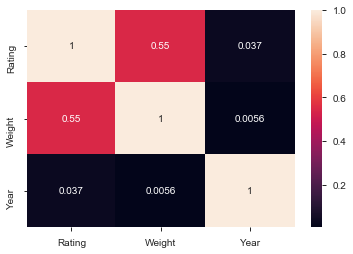

In [7]:
correlation_matrix = df.corr()
print(correlation_matrix)

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)

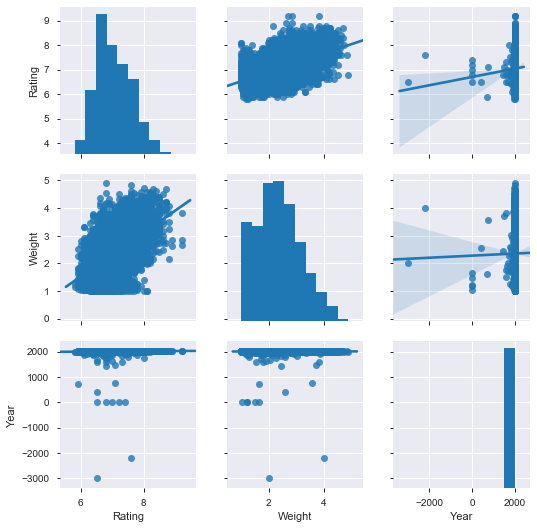

In [18]:
sns.pairplot(df, kind="reg")

## Data Wrangling

### Separate numeric and categorical columns/atributtes

In [19]:
num_list = df._get_numeric_data().columns

In [20]:
df_num = df[num_list]
df_num.head(3)

,Rating,Weight,Year
0,8.8,3.82,2017
1,8.6,2.83,2015
2,8.4,3.23,2016


In [21]:
df_cat = df.drop(num_list, axis=1)
df_cat.head(3)

,Age,Best number of players,Mechanisms,Number of players,Playing time
0,12+,— Best: 3,"['Action Retrieval', 'Campaign / Battle Card D...",1–4,60–120
1,13+,— Best: 4,"['Action Points', 'Cooperative Game', 'Hand Ma...",2–4,60
2,12+,— Best: 3,"['Card Drafting', 'End Game Bonuses', 'Hand Ma...",1–5,120


### Categoric variables

**Get Dummies**

In [22]:
df_cat_list = df_cat[['Mechanisms']]  
df_cat = df_cat[['Age','Best number of players','Number of players','Playing time']]

In [23]:
import ast

df_cat_list['Mechanisms']=df_cat_list['Mechanisms'].apply(ast.literal_eval)

df_cat_list = df_cat_list['Mechanisms'].apply(pd.Series).stack().str.get_dummies().sum(level=0)

df_cat_list.head(3)

,Acting,Action Drafting,Action Points,Action Queue,Action Retrieval,Action Timer,Action/Event,Advantage Token,Alliances,Area Majority / Influence,...,Turn Order: Stat-Based,Variable Phase Order,Variable Player Powers,Variable Setup,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,"Worker Placement, Different Worker Types",Zone of Control
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [24]:
for i in df_cat.columns:
    keys = df_cat[i].unique()
    values = range(len(keys))
    dictionary = dict(zip(keys, values))
    df_cat[i] = df_cat[i].replace(dictionary)
df_cat

,Age,Best number of players,Number of players,Playing time
0,0,0,0,0
1,1,1,1,1
2,0,0,2,2
3,2,2,1,0
4,2,0,1,2
...,...,...,...,...
4991,0,4,4,80
4992,5,10,8,51
4993,13,4,1,1
4994,3,15,25,1


### Numeric variables

**Binning variables for better prediction**

Plot all features against our label, 'Rating'

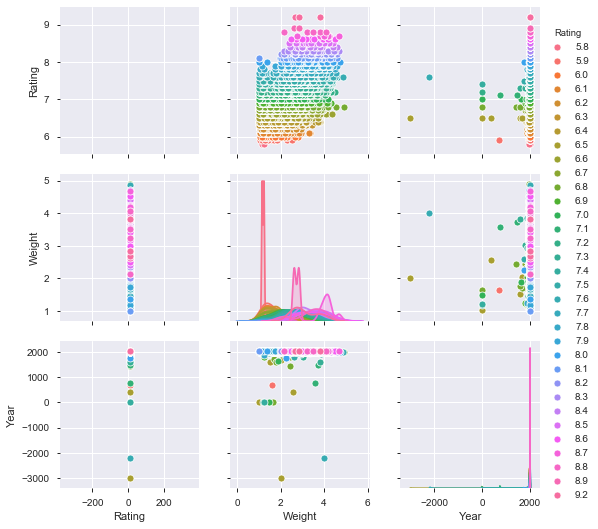

In [25]:
sns.pairplot(df_num,hue='Rating',palette="husl")

Weight and Rating are the only features which apparently could be binned

In [16]:
rating = []
weight = []

for i in df_num['Rating']:
    rating.append(i)
    
for i in df_num['Weight']:
    weight.append(i)
print('Rating range: ('+str(max(rating))+','+str(min(rating))+str(')'))
print('Weight range: ('+str(max(weight))+','+str(min(weight))+str(')'))

Rating range: (9.2,5.8)
Weight range: (4.89,1.0)


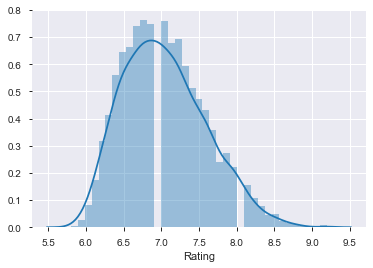

In [17]:
sns.distplot(df_num['Rating'])

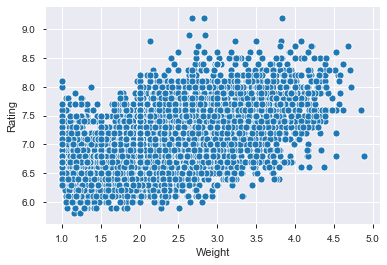

In [18]:
sns.scatterplot(df['Weight'],df['Rating'])  

**Binning Rating and Weight: Weight: 1-2, 2-3.5, 3.5-4.5, 4.5-5 , Rating 5.5-7, 7-9.5**

In [26]:
weight = []

for x in df_num['Weight']:
    if x >= 1 and x <2:
        weight.append(0)
    elif x >= 3.5 and x <=4.5:     
        weight.append(1)
    elif x >= 2 and x <3.5:
        weight.append(2)
    else:
        weight.append(3)

df_num['Weight'] = weight


rating = []

for x in df_num['Rating']:
    if x >= 5.5 and x <7:
        rating.append(0)
    else:
        rating.append(1)
        
df_num['Rating'] = rating
    

**Rating classes balance**

In [27]:
df_num['Rating'].value_counts()

1    2635
0    2361
Name: Rating, dtype: int64

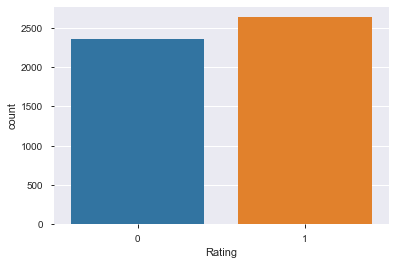

In [28]:
sns.countplot(df_num['Rating'])

### Final DataFrame for Machine Learning prediction: X,y

In [29]:
df_num.head(3)

,Rating,Weight,Year
0,1,1,2017
1,1,2,2015
2,1,2,2016


In [30]:
df_cat.head(3)

,Age,Best number of players,Number of players,Playing time
0,0,0,0,0
1,1,1,1,1
2,0,0,2,2


In [31]:
df_X = pd.concat((df_cat,df_num[['Weight','Rating']],df_cat_list),axis=1)
df_X.head(3)

,Age,Best number of players,Number of players,Playing time,Weight,Rating,Acting,Action Drafting,Action Points,Action Queue,...,Turn Order: Stat-Based,Variable Phase Order,Variable Player Powers,Variable Setup,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,"Worker Placement, Different Worker Types",Zone of Control
0,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,1,1,1,2,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,2,2,2,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Feature selection

In [32]:
y = df_X['Rating']
X = df_X.drop(['Rating'], axis=1)

In [33]:
num_feats = 178

# Pearson Correlation: 
# We check the absolute value of the Pearson’s correlation between the target and numerical features in our dataset. 
# We keep the top n features based on this criterion

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)

#  Chi-Squared
#calculate the chi-square metric between the target and the numerical variable and only select the variable with the maximum chi-squared values.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()

# Recursive Feature Elimination
# select features by recursively considering smaller and smaller sets of features

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()

# Lasso: SelectFromModel
# Embedded method. As said before, Embedded methods use algorithms that have built-in feature selection methods
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()


# Tree-based: SelectFromModel
# We calculate feature importance using node impurities in each decision tree. 
#In Random forest, the final feature importance is the average of all decision tree feature importance.
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()

In [26]:
# put all selection together
feature_name = X.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,Worker Placement,True,True,True,True,True,5
2,Weight,True,True,True,True,True,5
3,Variable Player Powers,True,True,True,True,True,5
4,Variable Phase Order,True,True,True,True,True,5
5,Trading,True,True,True,True,True,5
...,...,...,...,...,...,...,...
174,Auction: Dutch Priority,True,True,True,False,False,3
175,Auction: Dexterity,True,True,True,False,False,3
176,Alliances,True,True,True,False,False,3
177,Action Timer,True,True,True,False,False,3


**We will take the features with 5 and 4  Total score for higher Mechanisms variability when creating board game data**

In [27]:
mechanisms_worst = []
for x,y in zip(feature_selection_df['Feature'].tolist(), feature_selection_df['Total'].tolist()):
    if y == 3:
        mechanisms_worst.append(x)

In [28]:
feature_selection_list = feature_selection_df['Feature'].tolist()
[print(feature_selection_list.index(i)) for i in df_cat.columns]

32
28
17
15


[None, None, None, None]

Beside Mechanisms features, the other ones are in top 30 so we will use them. Also we could only select certain Mechanisms features if we want to generate only board games which could contain them.

## ML: Board game rating prediction

In [29]:
df_X = df_X.drop(mechanisms_worst, axis=1)

In [30]:
y = np.asarray(df_X['Rating'])
df_X = df_X.drop(['Rating'], axis=1)
X = np.asarray(df_X)

#Making sure X and y lenght its equal
print('len X:'+str(len(X)))
print('len y:'+str(len(y)))

len X:4996
len y:4996


In [31]:
df_X.head()

,Age,Best number of players,Number of players,Playing time,Weight,Acting,Action Drafting,Action Points,Action Queue,Action/Event,...,Turn Order: Role Order,Turn Order: Stat-Based,Variable Phase Order,Variable Player Powers,Variable Setup,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,"Worker Placement, Different Worker Types"
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,1,2,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,2,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2,2,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,2,0,1,2,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### K-Fold validation method

In [155]:
Method_KF = []
Acc_KF = []
Prec_KF = []
Rec_KF = []
F1_KF = []

### Logistic Regression

In [156]:
%%time

import warnings
warnings.filterwarnings("ignore")

logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(accuracy_score))   
Acc_KF.append(scores.mean())
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('Regresion Logistica_KF')

F1-score:  0.7187783225149654
Wall time: 3.91 s


### 3NN

In [157]:
%%time

clf_3nn = neighbors.KNeighborsClassifier(3, weights="distance")
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(accuracy_score))  
Acc_KF.append(scores.mean())
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('3NN_KF')

F1-score:  0.6262889420679775
Wall time: 2.93 s


### NBayes

In [158]:
%%time

gnb = GaussianNB()

scores = cross_val_score(gnb, X, y, cv=10, scoring = make_scorer(accuracy_score))   
Acc_KF.append(scores.mean())
scores = cross_val_score(gnb, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(gnb, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(gnb, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('NBayes_KF')

F1-score:  0.26369096458247915
Wall time: 942 ms


### SVM

In [69]:
#Estimate SVM best params

clf = svm.SVC()

params={'C':[0.1, 1.0],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [1,2,3],
        'gamma': ['scale'],
        #'coef0': [],
      #  'shrinking': [True,False],
        #'probability': [],
        #'tol': [1e-3,1e-2,1e-1],
        #'cache_size': [],
        #'class_weight': [],
        #'verbose': [True,False],
        #'max_iter': [-1],
       # 'decision_function_shape': ['ovo','ovr'],
        #'break_ties': [True,False],
        #'random_state': [],
        }

# GridSeacrh

grid_solver = GridSearchCV(estimator = clf, # model to train
                   param_grid = params, # param_grid
                   scoring = make_scorer(f1_score, average ="macro"),
                   cv = 5)
model_result_svm = grid_solver.fit(X,y)

In [70]:
model_result_svm.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [71]:
model_result_svm.best_score_

0.6824718302243611

In [72]:
model_result_svm.best_params_

{'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [159]:
%%time

from sklearn import svm
clf_svm = svm.SVC(kernel='linear', C = 1.0, gamma = 'scale', degree = 1) 

scores = cross_val_score(clf_svm, X, y, cv=10, scoring = make_scorer(accuracy_score)) 
Acc_KF.append(scores.mean())
scores = cross_val_score(clf_svm, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(clf_svm, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(clf_svm, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('SVM_KF')

F1-score:  0.7368631571429989
Wall time: 23min 24s


### Perceptron

In [160]:
%%time

from sklearn.linear_model import Perceptron
clf_per = Perceptron(max_iter=2000, random_state=0, n_jobs=2)

scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(accuracy_score))   
Acc_KF.append(scores.mean())
scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('Perceptron_KF')

F1-score:  0.5026568720940638
Wall time: 1.59 s


### Random Forest

In [75]:
#Estime RandomForest best params
import warnings
warnings.filterwarnings("ignore")

clf = RandomForestClassifier()

params={'criterion':['gini',"entropy"],
        'max_depth': [5,10,20],# Maxima pofundidad del arbol
        'max_features': [2, 3, 4], # numero de features a considerar en cada split
        'max_leaf_nodes': [5,10], # maximo de nodos del arbol
        'min_impurity_decrease' : [0.02], # un nuevo nodo se hará si al hacerse se decrece la impureza
        'min_samples_split': [3], # The minimum number of samples required to split an internal node
        'n_estimators':[ 100,200,300]
        }

# GridSeacrh

grid_solver = GridSearchCV(estimator = clf, # model to train
                   param_grid = params, # param_grid
                   scoring = make_scorer(f1_score, average ="macro"),
                   cv = 5)

model_result = grid_solver.fit(X,y)

In [76]:
model_result.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=2, max_leaf_nodes=5,
                       min_impurity_decrease=0.02, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [77]:
model_result.best_score_

0.3453020448924557

In [78]:
model_result.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 2,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 0.02,
 'min_samples_split': 3,
 'n_estimators': 100}

In [161]:
%%time

clf_rf = RandomForestClassifier(criterion='gini',max_depth=5,max_features=2,min_impurity_decrease= 0.02, max_leaf_nodes=5,min_samples_split = 3,n_estimators=100)

scores = cross_val_score(clf_rf, X, y, cv=10, scoring = make_scorer(accuracy_score))   
Acc_KF.append(scores.mean())
scores = cross_val_score(clf_rf, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(clf_rf, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(clf_rf, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('RandomForest_KF')

F1-score:  0.6906037553744341
Wall time: 4.82 s


### AdaBoost

In [162]:
#Estime RandomForest best params

import warnings
warnings.filterwarnings("ignore")

clf = AdaBoostClassifier()

params={
        'n_estimators': [1000,500],# Maxima pofundidad del arbol
        'learning_rate': [2, 1, 3], # numero de features a considerar en cada split
        'algorithm': ['SAMME','SAMME.R'], # maximo de nodos del arbol
        }

# GridSeacrh

grid_solver = GridSearchCV(estimator = clf, # model to train
                   param_grid = params, # param_grid
                   scoring = make_scorer(f1_score, average ="macro"),
                   cv = 5)

model_result = grid_solver.fit(X,y)

In [81]:
model_result.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=500, random_state=None)

In [82]:
model_result.best_score_

0.7189361525116735

In [83]:
model_result.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 500}

In [84]:
%%time

clf_ada = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 1, n_estimators = 500)
clf_ada.fit(X, y)

scores = cross_val_score(clf_ada, X, y, cv=10, scoring = make_scorer(accuracy_score))   
Acc_KF.append(scores.mean())
scores = cross_val_score(clf_ada, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(clf_ada, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(clf_ada, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('Adaboost_KF')

F1-score:  0.7403827069677267
Wall time: 2min 49s


### Hybrid Classifier

In [163]:
%%time

clf0 = svm.SVC(kernel='linear', C = 1.0, gamma = 'scale', degree = 1) 
clf1 = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 1, n_estimators = 500)
clf1.fit(X, y)
clf2 = RandomForestClassifier(criterion='gini',max_depth=5,max_features=2,min_impurity_decrease= 0.02, max_leaf_nodes=5,min_samples_split = 3,n_estimators=100)

clf = VotingClassifier(estimators=[('svm', clf0),('ada', clf1), ('rf', clf2)], voting='hard', weights=[1,1,1], n_jobs=-1)

clf1 = clf.fit(X, y)

scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(accuracy_score))   
Acc_KF.append(scores.mean())
scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(precision_score))
Prec_KF.append(scores.mean())
scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(recall_score))
Rec_KF.append(scores.mean())
scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(f1_score))
F1_KF.append(scores.mean())
print("F1-score: ", scores.mean())

Method_KF.append('Clasificador Hibrido_KF')


F1-score:  0.7509211220854045
Wall time: 24min 46s


### Classifiers and validation method comparisson

In [164]:
metrics = ['Method','Accuracy','Precision','Recall', 'F1-score']
df_results = pd.DataFrame(columns =metrics)

df_results['Method'] = Method_KF
df_results['Accuracy'] = Acc_KF
df_results['Precision'] = Prec_KF
df_results['Recall'] = Rec_KF
df_results['F1-score'] = F1_KF
df_results

,Method,Accuracy,Precision,Recall,F1-score
0,Regresion Logistica_KF,0.702355,0.716313,0.722197,0.718778
1,3NN_KF,0.620287,0.651194,0.603408,0.626289
2,NBayes_KF,0.543772,0.823893,0.168731,0.263691
3,SVM_KF,0.695554,0.677860,0.808724,0.736863
4,Perceptron_KF,0.579663,0.652136,0.498992,0.502657
5,RandomForest_KF,0.527422,0.527422,1.000000,0.690604
6,Clasificador Hibrido_KF,0.700952,0.670430,0.855008,0.750921


### Hybrid classifier: estimate better weights 

In [166]:
%%time

clf0 = svm.SVC(kernel='linear', C = 1.0, gamma = 'scale', degree = 1) 
clf1 = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 1, n_estimators = 500)
clf1.fit(X, y)
clf2 = RandomForestClassifier(criterion='gini',max_depth=5,max_features=2,min_impurity_decrease= 0.02, max_leaf_nodes=5,min_samples_split = 3,n_estimators=100)

n = 10
while n > 0:
    weights = []
    for i in range (1,4):
        weights.append(random.uniform(0.5,1.5))

    clf = VotingClassifier(estimators=[('svm', clf0),('ada', clf1), ('rf', clf2)], voting='hard', weights=weights , n_jobs=-1)
    clf1 = clf.fit(X, y)
    scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(f1_score))
    print("F1-score: ", scores.mean())
    print('Pesos: ',weights )
    n -= 1

F1-score:  0.7509211220854045
Pesos:  [1.0205287389752145, 1.4624829608189787, 1.117327400516507]
F1-score:  0.7509211220854045
Pesos:  [0.8262341759886362, 1.0364341433480722, 1.0121033182568286]
F1-score:  0.7368631571429989
Pesos:  [1.488829232207908, 0.8847021827341229, 0.5564643684068847]
F1-score:  0.7368631571429989
Pesos:  [0.9920916165612501, 0.8156413732258831, 0.9260372954348908]
F1-score:  0.7368631571429989
Pesos:  [0.9802783493720069, 0.6695240059270744, 0.8656678129946593]
F1-score:  0.7368631571429989
Pesos:  [1.0242179622116936, 0.5902291109813036, 0.5205291208117082]
F1-score:  0.7368631571429989
Pesos:  [1.4965965529175638, 1.4185021964405085, 1.3177613790265843]
F1-score:  0.7368631571429989
Pesos:  [1.0616952965068678, 1.2865480648314296, 0.9745341425045754]
F1-score:  0.7368631571429989
Pesos:  [0.8698503684067469, 1.3687712837644248, 1.4443160066198186]
F1-score:  0.7368631571429989
Pesos:  [0.850574507125066, 0.5109199418371947, 1.2681535119536886]
Wall time: 4h

## High rating Board Games prediction

**Train Hybrid Classifier**

In [32]:
%%time

from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

clf0 = svm.SVC(kernel='linear', C = 1.0, gamma = 'scale', degree = 1) 
clf1 = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 1, n_estimators = 500)
clf1.fit(X, y)
clf2 = RandomForestClassifier(criterion='gini',max_depth=5,max_features=2,min_impurity_decrease= 0.02, max_leaf_nodes=5,min_samples_split = 3,n_estimators=100)

clf = VotingClassifier(estimators=[('svm', clf0),('ada', clf1), ('rf', clf2)], voting='hard', weights=[1.2130770082041478, 1.3892687725509578, 1.3054265842709998], n_jobs=-1)

clf1 = clf.fit(X, y)

scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(accuracy_score))   #cross_val_score: te da el score (clasificador, dataset X e y, cv =numero de k,scoring=)
print("Accuracy: ", scores.mean())
scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(precision_score))
print("Precision: ", scores.mean())
scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(recall_score))
print("Recall: ", scores.mean())
scores = cross_val_score(clf1, X, y, cv=10, scoring = make_scorer(f1_score))
print("F1-score: ", scores.mean())

Accuracy:  0.7009524926099705
Precision:  0.6704300383484777
Recall:  0.855007777393709
F1-score:  0.7509211220854045
Wall time: 46min 26s


**Confusion matrix**

In [89]:
from sklearn.model_selection import cross_val_predict

y_test = y.copy()
y_pred = cross_val_predict(clf1,X,y,cv=10)
print(y_test)
print(y_pred)

[1 1 1 ... 0 1 1]
[1 1 1 ... 1 0 1]


In [90]:
print ('Confusion Matrix :')
cnf_matrix = confusion_matrix(y_test,y_pred)
print(cnf_matrix)
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print('Classification Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[1249 1112]
 [ 382 2253]]
Accuracy Score : 0.7009607686148919
Classification Report : 
              precision    recall  f1-score   support

           0       0.77      0.53      0.63      2361
           1       0.67      0.86      0.75      2635

    accuracy                           0.70      4996
   macro avg       0.72      0.69      0.69      4996
weighted avg       0.72      0.70      0.69      4996



In [91]:
TP = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TN = cnf_matrix[1][1]

In [92]:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Precision = (TP) / (TP + FP)
Recall = (TP) / (TP + FN)
Specificity = (TN) / (TN + FP)

print('Accuracy ',Accuracy)
print('Precision ', Precision)
print('Recall ', Recall)
print('Specificity ', Specificity)

Accuracy  0.7009607686148919
Precision  0.5290131300296484
Recall  0.765787860208461
Specificity  0.6695393759286775


**Creating random board games/data with a High Rating**

In [69]:
#Get values of atributes : dummies and corresponding text/original value

age_text = df['Age'].unique().tolist()
age_text.pop(-5)
age_dummies = list(range(0,len(age_text)))

#number_text = df['Number of players'].unique().tolist()
number_text=['1','2','3','1-2','1-3','1-4','2-3','2-4','2-5']
number_dummies = list(range(0,len(number_text)))

#best_text = df['Best number of players'].unique().tolist()
best_text=['1','2','3','4','5','1-2','1-3','1-4','2-3','2-4','2-5','1+','2+','3+','4+']
best_dummies = list(range(0,len(best_text)))

#time_text = df['Playing time'].unique().tolist()
time_text=['15','30','45','60','90','120','180','15-30','30-45','30-90','45-60','60-120','240-480','120-180']
time_dummies = list(range(0,len(time_text)))

weight_dummies = df_num['Weight'].unique().tolist()
weight_text = ['3.5-4.5', '2-3.5','1-2','4.5-5']

mechanims_text = df_X.iloc[:,5:].astype(int).columns

#Generate patterns to test

bgs=[]
rating_predic = []    

n = 10
while n > 0:
    mechanims_dummies = np.random.choice([0, 1], size=105,p=[.98, .02])
    if 1 in mechanims_dummies:
        bg = [random.choice(age_dummies),random.choice(number_dummies),random.choice(best_dummies),random.choice(time_dummies),random.choice(weight_dummies)]
        bg = np.append(bg,mechanims_dummies)
        bg_list = bg.tolist()
        
        age_bg = age_text[age_dummies.index(bg_list[0])]
        number_bg = number_text[number_dummies.index(bg_list[1])]
        best_bg = best_text[best_dummies.index(bg_list[2])]
        time_bg = time_text[time_dummies.index(bg_list[3])]
        weight_bg = weight_text[weight_dummies.index(bg_list[4])]
        mechanims_bg = []
        for x,y in zip(mechanims_dummies,mechanims_text):
            if x == 1:
                mechanims_bg.append(y)


        if number_bg =='1':
            bg_text = [age_bg,number_bg,'-',time_bg,weight_bg,mechanims_bg]
        else:
            bg_text = [age_bg,number_bg,best_bg,time_bg,weight_bg,mechanims_bg]

        if bg_text[1] == '1' or (bg_text[1] == '2' and (bg_text[2] == '1' or bg_text[2] =='2')) or (bg_text[1] == '3' and (bg_text[2] == '1' or bg_text[2] =='2' or bg_text[2] == '3' or bg_text[2]== '1+'or bg_text[2] == '2+' or bg_text[2] == '1-2'or bg_text[2]== '1-3'or bg_text[2] == '2-3' )) or (bg_text[1] =='4' and (bg_text[2] == '1' or bg_text[2]=='2' or bg_text[2] == '3' or bg_text[2]== '4' or bg_text[2]== '1+'or bg_text[2] == '2+'or bg_text[2] == '3+'or bg_text[2] == '1-2'or bg_text[2] == '1-3'or bg_text[2] == '2-3' or bg_text[2] =='1-4' or bg_text[2] =='2-4')) or (bg_text[1] =='5' and (bg_text[2] == '1' or bg_text[2]=='2' or bg_text[2] == '3' or bg_text[2] == '4' or bg_text[2]=='5' or bg_text[2] == '1+'or bg_text[2] == '2+'or bg_text[2] == '3+'or bg_text[2]=='4+' or bg_text[2]== '1-2'or bg_text[2] == '1-3'or bg_text[2] == '2-3' or bg_text[2] =='1-4' or bg_text[2] =='2-4' or bg_text[2] =='2-5')):
            if bg not in bgs:
                X_test = np.asarray(bg)
                X_test = np.reshape(X_test,(-1,110))
                bg_class = clf1.predict(X_test)
                if bg_class[0]==1:
                    rating_predic.append(bg_class)
                    bgs.append(bg_text)
                    n-=1

In [71]:
pd.DataFrame(bgs, columns=['Age','Number of players','Best number of players','Playing time','Weight','Mechanims'])

,Age,Number of players,Best number of players,Playing time,Weight,Mechanims
0,13+,2,1,120,2-3.5,"[Auction: Turn Order Until Pass, Three Dimensi..."
1,12+,3,1-2,45,4.5-5,"[Set Collection, Traitor Game]"
2,16+,3,1+,30,2-3.5,"[Acting, Ownership]"
3,17+,1,-,45-60,4.5-5,[Increase Value of Unchosen Resources]
4,8+,1,-,15-30,2-3.5,"[Catch the Leader, Communication Limits, Order..."
5,18+,1,-,240-480,2-3.5,"[Area Majority / Influence, Variable Player Po..."
6,12+,1,-,240-480,1-2,"[Action Drafting, Area Movement, Hidden Moveme..."
7,14+,3,2-3,45,1-2,"[Action/Event, Three Dimensional Movement, Wor..."
8,16+,3,2+,45-60,2-3.5,"[Melding and Splaying, Modular Board]"
9,17+,1,-,60-120,4.5-5,"[Commodity Speculation, Race]"


# Natural Language Processing

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
field_names = {'Name','Rating','Year','Description'} 
url = 'https://raw.githubusercontent.com/Sampayob/Boardgames-meets-Data science/master/BGGtop400-Description.csv'
df = pd.read_csv(url, delimiter = ',',names=field_names, encoding='utf-8-sig')
df.columns = ['Year','Name','Rating','Description']
df.head()

,Year,Name,Rating,Description
0,(2017),Gloomhaven,8.8,Gloomhaven is a game of Euro-inspired tactical...
1,(2015),Pandemic Legacy: Season 1,8.6,Pandemic Legacy is a co-operative campaign gam...
2,(2016),Terraforming Mars,8.4,"In the 2400s, mankind begins to terraform the ..."
3,(2018),Brass: Birmingham,8.6,Brass: Birmingham is an economic strategy game...
4,(2015),Through the Ages: A New Story of Civilization,8.5,Through the Ages: A New Story of Civilization ...


## Transforming boardgames description in tokens

**Getting each description as a string**

In [4]:
descriptions = []
for i in df['Description']:
    descriptions.append(i)
descriptions[0:2]

['Gloomhaven is a game of Euro-inspired tactical combat in a persistent world of shifting motives. Players will take on the role of a wandering adventurer with their own special set of skills and their own reasons for traveling to this dark corner of the world. Players must work together out of necessity to clear out menacing dungeons and forgotten ruins. In the process, they will enhance their abilities with experience and loot, discover new locations to explore and plunder, and expand an ever-branching story fueled by the decisions they make.\nThis is a game with a persistent and changing world that is ideally played over many game sessions. After a scenario, players will make decisions on what to do, which will determine how the story continues, kind of like a “Choose Your Own Adventure” book. Playing through a scenario is a cooperative affair where players will fight against automated monsters using an innovative card system to determine the order of play and what a player does on 

In [5]:
text = ''.join(descriptions)
text[0:2000]

"Gloomhaven is a game of Euro-inspired tactical combat in a persistent world of shifting motives. Players will take on the role of a wandering adventurer with their own special set of skills and their own reasons for traveling to this dark corner of the world. Players must work together out of necessity to clear out menacing dungeons and forgotten ruins. In the process, they will enhance their abilities with experience and loot, discover new locations to explore and plunder, and expand an ever-branching story fueled by the decisions they make.\nThis is a game with a persistent and changing world that is ideally played over many game sessions. After a scenario, players will make decisions on what to do, which will determine how the story continues, kind of like a “Choose Your Own Adventure” book. Playing through a scenario is a cooperative affair where players will fight against automated monsters using an innovative card system to determine the order of play and what a player does on t

**Making tokens from text**

In [6]:
words=' '.join(x.lower() for x in text.split())
words = word_tokenize(words)

**Filter tokens through stop words and punctuation marks**

In [7]:
# Stopwords
stop_words = nltk.corpus.stopwords.words('english')
stopw = ['player','players','card','take','number' , 'nin','nthe' 'games', 'takes' , 'play','may','first','end', 'get','building' , 'victory','tiles','also','time','game','one','two','three','four','five','action','build','new','will','set','tile','color','move','rule','six','nThe','board game','board','use','even','goal','either','good','different','every','must','well','become','different','turn','order','round','nIn','wor','x80','x99','order','system','place','need','many','start','based','great','player','x93','Player','x93','start','great','game','world','unique','actions','face','choose','gain','come','side','small','location','point','cities','make','win','players take','used','placed','find','various','acquire','way','hand','special','want','allow','around','include','another','possible','develop','now','influence','back','best','available','increase','represent','rules','along','help','give','part','feature','original','enough']

for w in stopw:
    stop_words.append(w)
    
# Filter tokens
tokens =[]
for w in words:
    if w not in stop_words:
        if len(w) > 2:
            tokens.append(w)

## Text analysis

### Searching for a word frequency

In [8]:
tokens.count("hero")

17

### Most common words

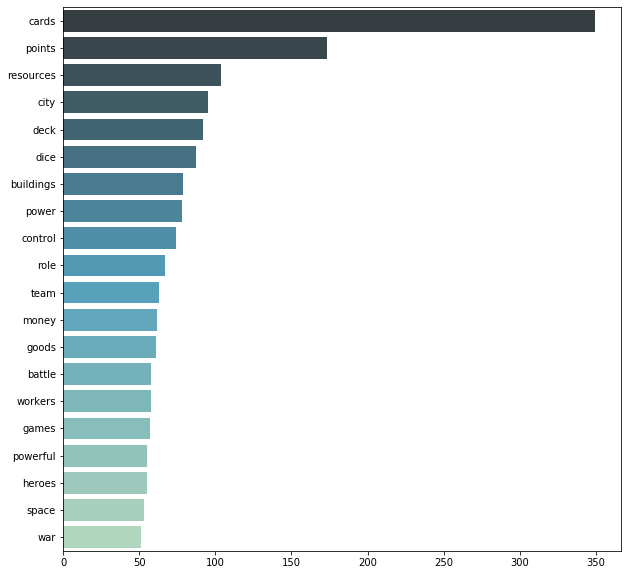

In [176]:
import collections
import seaborn as sns

counter=collections.Counter(tokens)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop_words):
        x.append(word)
        y.append(count)
plt.figure(figsize=(10,10))
sns.barplot(x=y,y=x,palette="GnBu_d")

In [8]:
fdist = FreqDist(tokens)
fdist.most_common(20)

[('cards', 349),
 ('points', 173),
 ('resources', 104),
 ('city', 95),
 ('deck', 92),
 ('dice', 87),
 ('buildings', 79),
 ('power', 78),
 ('control', 74),
 ('role', 67),
 ('team', 63),
 ('money', 62),
 ('goods', 61),
 ('battle', 58),
 ('workers', 58),
 ('powerful', 55),
 ('heroes', 55),
 ('space', 53),
 ('war', 51),
 ('land', 50)]

### WordCloud

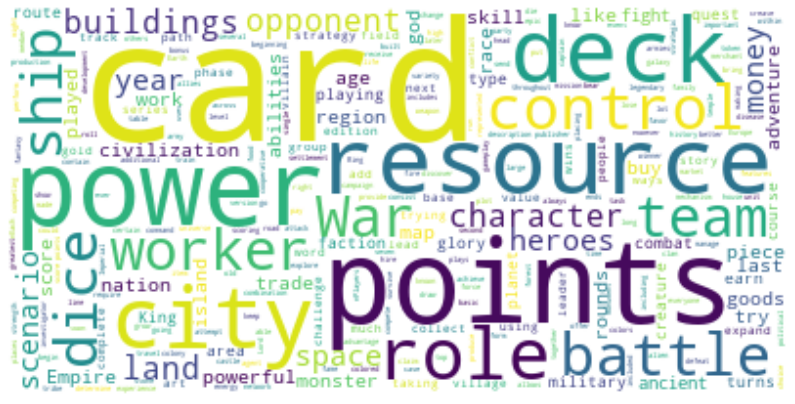

In [9]:
from wordcloud import WordCloud

boardgame_wc = WordCloud(background_color='white', max_words=2000, stopwords=stop_words)
boardgame_wc.generate(str(descriptions))

# display the word cloud

import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(boardgame_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Word context

In [42]:
text_nltk=nltk.Text(tokens) 
text_nltk.concordance("hero")

Displaying 17 of 17 matches:
hly adventure packs contain scenario hero cards deck base 1-2 additional base 
eck needed villain particular scheme hero decks spider-man hulk cyclops wolver
e etc shuffle together since handful hero decks fifteen included hero deck var
 handful hero decks fifteen included hero deck vary widely terms course recrui
widely terms course recruit powerful hero cards add deck stronger resourceful 
ls traits equipment elements perfect hero ready opposition quest glory riches 
ibutes purchase weapons armor outfit hero train skills discover hero traits pr
or outfit hero train skills discover hero traits prepare journey earn reputati
avoc lords hellas control asymmetric hero developed increasing basic statistic
 gods offering seat heaven whichever hero defeats rivals courage wits precious
aliens t-rex-riding orc large dragon hero squad details movement combat abilit
aracters taking role classic western hero archetype law man gunslinger saloon 
 adventures experience 

### Bigrams: pairs of words which convey a significant amount of information 

In [18]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

bigram_measures = nltk.collocations.BigramAssocMeasures()
tokens_finder = BigramCollocationFinder.from_words(tokens)
tokens_scored = tokens_finder.score_ngrams(bigram_measures.raw_freq)
list(tokens_scored[0:10])

[(('score', 'points'), 0.0006674629382421134),
 (('deck', 'cards'), 0.0005620740532565166),
 (('description', 'publisher'), 0.0005620740532565166),
 (('second', 'edition'), 0.0004566851682709197),
 (('star', 'wars'), 0.0003864259116138551),
 (('cards', 'deck'), 0.00035129628328532284),
 (('united', 'states'), 0.00035129628328532284),
 (('jack', 'ripper'), 0.00031616665495679057),
 (('playing', 'cards'), 0.00031616665495679057),
 (('resource', 'management'), 0.00031616665495679057)]

### Relevant words of each game description

In [21]:
names = []
[names.append(d.replace(" ", "").replace(":", "")) for d in df['Name']]

names_desc = []

for i,j in zip(descriptions,df['Name']):
    d = globals()["{0}".format(j.replace(" ", "").replace(":", ""))]=nlp(i)
    names_desc.append(d)

In [28]:
from collections import OrderedDict
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import en_core_web_sm
nlp = en_core_web_sm.load()

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        
        
tr4w = TextRank4Keyword()
tr4w.analyze(descriptions[22], candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
str(tr4w.get_keywords(10))

bird - 2.4471249999999998
game - 1.838627314814815
habitats - 1.4739930555555554
dice - 1.3764555555555553
engine - 1.2524027777777778
board - 1.2309953703703704
miniatures - 1.1724319444444444
variety - 1.1665291666666664
birds - 1.1364722222222223
collectors - 1.1305694444444445
colors - 1.1149388888888887
custom - 1.0977263888888888


'None'